In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib

In [2]:
df = pd.read_csv("E:/Projects/fraud detection/Data/Fraud Detection Dataset.csv")
df.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent
0,T1,4174,1292.76,ATM Withdrawal,16.0,Tablet,San Francisco,0,119,13,Debit Card,0
1,T2,4507,1554.58,ATM Withdrawal,13.0,Mobile,New York,4,79,3,Credit Card,0
2,T3,1860,2395.02,ATM Withdrawal,NaN,Mobile,NaN,3,115,9,NaN,0
3,T4,2294,100.10,Bill Payment,15.0,Desktop,Chicago,4,3,4,UPI,0
4,T5,2130,1490.50,POS Payment,19.0,Mobile,San Francisco,2,57,7,Credit Card,0


In [7]:
df.isna().sum()
df = df.dropna()
df.shape

(38895, 12)

Text(0.5, 1.0, 'Distribution of Fraudulent Transactions')

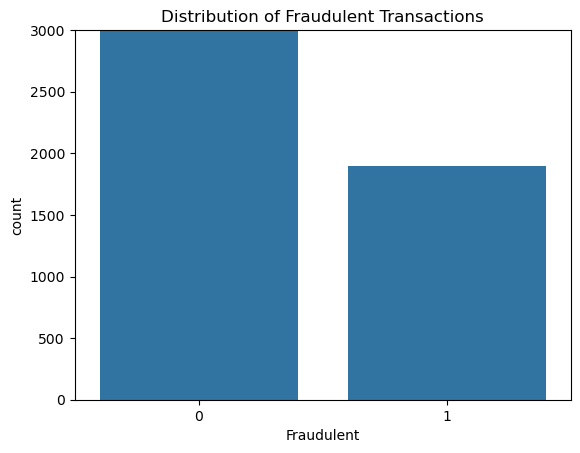

In [8]:
sns.countplot(x='Fraudulent', data=df)
plt.ylim(0, 3000)
plt.title('Distribution of Fraudulent Transactions')    

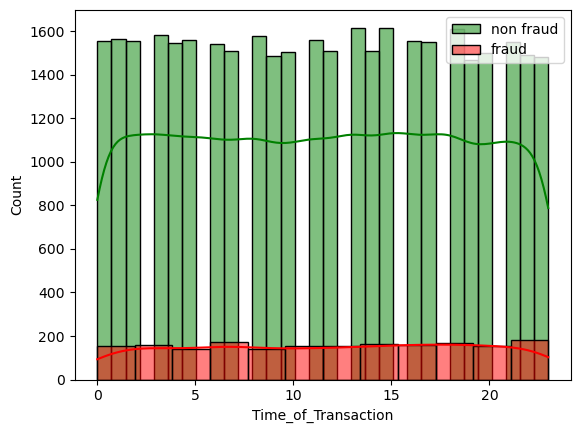

In [9]:
sns.histplot(df[df['Fraudulent'] == 0]['Time_of_Transaction'], label='non fraud',color='green', kde=True)
sns.histplot(df[df['Fraudulent'] == 1]['Time_of_Transaction'], label='fraud', color='red', kde=True)
plt.legend()
plt.show()

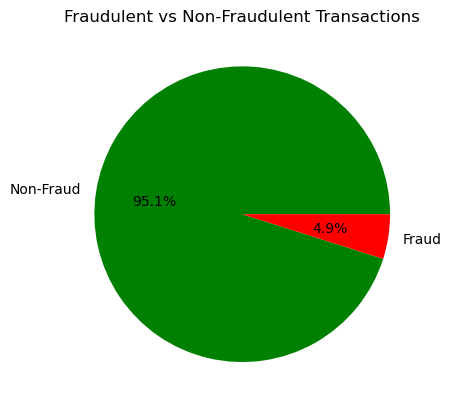

In [10]:
# ...existing code...
df['Fraudulent'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Non-Fraud', 'Fraud'], colors=['green', 'red'])
plt.title('Fraudulent vs Non-Fraudulent Transactions')
plt.ylabel('')
plt.show()
# ...existing code...

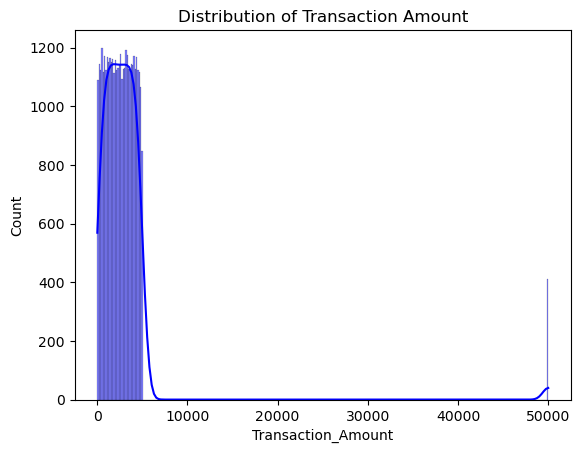

In [17]:
sns.histplot(df['Transaction_Amount'], kde=True, color='blue')
plt.title('Distribution of Transaction Amount')
plt.show()

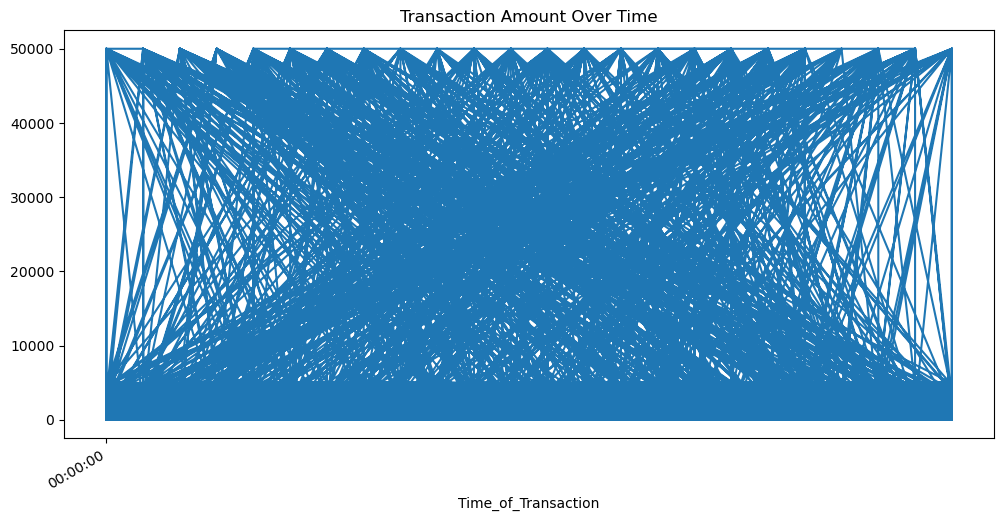

In [18]:
df['Time_of_Transaction'] = pd.to_datetime(df['Time_of_Transaction'])  # Ensure it's datetime
df.set_index('Time_of_Transaction')['Transaction_Amount'].plot(figsize=(12, 6))
plt.title('Transaction Amount Over Time')
plt.show()

In [24]:
df['Time_of_Transaction'] = pd.to_datetime(df['Time_of_Transaction'], errors='coerce')

# Check for any NaT (if parsing fails)
print(df['Time_of_Transaction'].head())

0   1970-01-01 00:00:00.000000016
1   1970-01-01 00:00:00.000000013
3   1970-01-01 00:00:00.000000015
4   1970-01-01 00:00:00.000000019
5   1970-01-01 00:00:00.000000015
Name: Time_of_Transaction, dtype: datetime64[ns]


In [31]:
# Suppose your original 'Time_of_Transaction' was the integer:
df['Hour'] = df['Time_of_Transaction'].dt.nanosecond  # This is probably where it's hiding

print(df[['Time_of_Transaction', 'Hour']].head())


            Time_of_Transaction  Hour
0 1970-01-01 00:00:00.000000016    16
1 1970-01-01 00:00:00.000000013    13
3 1970-01-01 00:00:00.000000015    15
4 1970-01-01 00:00:00.000000019    19
5 1970-01-01 00:00:00.000000015    15


In [33]:
df['Is_Night'] = df['Hour'].apply(lambda x: 1 if x < 6 else 0)


In [39]:
# 1. Calculate user average amount
df['User_Avg_Amount'] = df.groupby('User_ID')['Transaction_Amount'].transform('mean')

# 2. Calculate ratio: how big is this transaction vs. average?
df['Amount_vs_User_Avg'] = df['Transaction_Amount'] / df['User_Avg_Amount']

# 3. Optional: flag if it’s unusually high (say, >2x average)
df['Is_Unusual_Amount'] = (df['Amount_vs_User_Avg'] > 2).astype(int)

print(df[['Transaction_Amount', 'User_Avg_Amount', 'Amount_vs_User_Avg', 'Is_Unusual_Amount']].tail(400))


       Transaction_Amount  User_Avg_Amount  Amount_vs_User_Avg  \
49612             1819.11      2074.411429            0.876928   
49614              730.70      2468.865000            0.295966   
49615             2578.30      2163.090000            1.191952   
49616             4188.62      2686.223333            1.559297   
49617              536.62      2675.832857            0.200543   
...                   ...              ...                 ...   
50947             1073.04      1810.884615            0.592550   
50975             1826.49      1782.870000            1.024466   
50985              544.53      1851.988182            0.294025   
50997             2204.43      2583.210000            0.853368   
50999              814.72      2389.793636            0.340916   

       Is_Unusual_Amount  
49612                  0  
49614                  0  
49615                  0  
49616                  0  
49617                  0  
...                  ...  
50947             

In [46]:
# Example threshold: more than 5 transactions in last 24H
df['High_Frequency'] = (df['Number_of_Transactions_Last_24H'] > 5).astype(int)

print(df[['Number_of_Transactions_Last_24H', 'High_Frequency']].head())


   Number_of_Transactions_Last_24H  High_Frequency
0                               13               1
1                                3               0
3                                4               0
4                                7               1
5                               14               1


In [62]:
df.dropna(subset=['Transaction_Amount', 'Time_of_Transaction','Location','Device_Used','Payment_Method'], inplace=True)            

In [51]:
df['Is_Night_High'] = ((df['Is_Night'] == 1) & (df['Is_Unusual_Amount'] == 1)).astype(int)

In [71]:
df['Time_of_Transaction'] = pd.to_datetime(df['Time_of_Transaction'], errors='coerce')


In [72]:
df['Hour'] = df['Time_of_Transaction'].dt.nanosecond  

In [73]:
df['Is_Night'] = df['Hour'].apply(lambda x: 1 if x < 6 else 0)

In [75]:
# 1. Calculate user average amount
df['User_Avg_Amount'] = df.groupby('User_ID')['Transaction_Amount'].transform('mean')

# 2. Calculate ratio: how big is this transaction vs. average?
df['Amount_vs_User_Avg'] = df['Transaction_Amount'] / df['User_Avg_Amount']

# 3. Optional: flag if it’s unusually high (say, >2x average)
df['Is_Unusual_Amount'] = (df['Amount_vs_User_Avg'] > 2).astype(int)

print(df[['Transaction_Amount', 'User_Avg_Amount', 'Amount_vs_User_Avg', 'Is_Unusual_Amount']].head())


   Transaction_Amount  User_Avg_Amount  Amount_vs_User_Avg  Is_Unusual_Amount
0             1292.76      2317.639231            0.557792                  0
1             1554.58      2923.454444            0.531761                  0
3              100.10      2626.630588            0.038110                  0
4             1490.50      2546.430000            0.585329                  0
5             2372.04      2374.481818            0.998972                  0


In [76]:
# Example threshold: more than 5 transactions in last 24H
df['High_Frequency'] = (df['Number_of_Transactions_Last_24H'] > 5).astype(int)

print(df[['Number_of_Transactions_Last_24H', 'High_Frequency']].head())


   Number_of_Transactions_Last_24H  High_Frequency
0                               13               1
1                                3               0
3                                4               0
4                                7               1
5                               14               1


In [78]:
df['Is_Night_High'] = ((df['Is_Night'] == 1) & (df['Is_Unusual_Amount'] == 1)).astype(int)



In [79]:
df.head()

,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent,Hour,Is_Night,User_Avg_Amount,Amount_vs_User_Avg,Is_Unusual_Amount,High_Frequency,Is_Night_High
0,4174,1292.76,ATM Withdrawal,1970-01-01 00:00:00.000000016,Tablet,San Francisco,0,119,13,Debit Card,0,16,0,2317.639231,0.557792,0,1,0
1,4507,1554.58,ATM Withdrawal,1970-01-01 00:00:00.000000013,Mobile,New York,4,79,3,Credit Card,0,13,0,2923.454444,0.531761,0,0,0
3,2294,100.10,Bill Payment,1970-01-01 00:00:00.000000015,Desktop,Chicago,4,3,4,UPI,0,15,0,2626.630588,0.038110,0,0,0
4,2130,1490.50,POS Payment,1970-01-01 00:00:00.000000019,Mobile,San Francisco,2,57,7,Credit Card,0,19,0,2546.430000,0.585329,0,1,0
5,2095,2372.04,ATM Withdrawal,1970-01-01 00:00:00.000000015,Desktop,Boston,3,96,14,Credit Card,0,15,0,2374.481818,0.998972,0,1,0


In [3]:
df.columns

Index(['User_ID', 'Transaction_Amount', 'Transaction_Type',
       'Time_of_Transaction', 'Device_Used', 'Location',
       'Previous_Fraudulent_Transactions', 'Account_Age',
       'Number_of_Transactions_Last_24H', 'Payment_Method', 'Fraudulent',
       'Hour', 'Is_Night', 'User_Avg_Amount', 'Amount_vs_User_Avg',
       'Is_Unusual_Amount', 'High_Frequency', 'Is_Night_High'],
      dtype='object')

In [5]:

X = df[[
    'Transaction_Amount',
    'Amount_vs_User_Avg',
    'Is_Night_High',
    'Number_of_Transactions_Last_24H',
    'High_Frequency',
    'Previous_Fraudulent_Transactions',
    'Account_Age',
    'Transaction_Type',
    'Device_Used',
    'Payment_Method'
]]

y = df['Fraudulent']

#  One-hot encode
X = pd.get_dummies(
    X,
    columns=['Transaction_Type', 'Device_Used', 'Payment_Method'],
    drop_first=True
)

# Train-test 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#  Random Forest 
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)

model.fit(X_train, y_train)

#  Predict PROBABILITY
y_proba = model.predict_proba(X_test)[:, 1]

# Try lower threshold to catch more frauds!
y_pred = (y_proba >= 0.3).astype(int)

#  Evaluatation

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))



importances = model.feature_importances_
features = X_train.columns

feat_imp = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_imp)


              precision    recall  f1-score   support

           0       0.95      1.00      0.98      7531
           1       0.70      0.05      0.10       386

    accuracy                           0.95      7917
   macro avg       0.83      0.53      0.54      7917
weighted avg       0.94      0.95      0.93      7917

[[7522    9]
 [ 365   21]]
                             Feature  Importance
1                 Amount_vs_User_Avg    0.213347
0                 Transaction_Amount    0.211873
6                        Account_Age    0.195240
3    Number_of_Transactions_Last_24H    0.110564
5   Previous_Fraudulent_Transactions    0.073165
12                Device_Used_Tablet    0.021127
16        Payment_Method_Net Banking    0.019850
17                Payment_Method_UPI    0.019669
14         Payment_Method_Debit Card    0.019088
9   Transaction_Type_Online Purchase    0.018765
10      Transaction_Type_POS Payment    0.017629
11                Device_Used_Mobile    0.017301
8      Tr

C:\Users\sanja\AppData\Local\Temp\ipykernel_12548\1621049777.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp.head(15), palette='viridis')


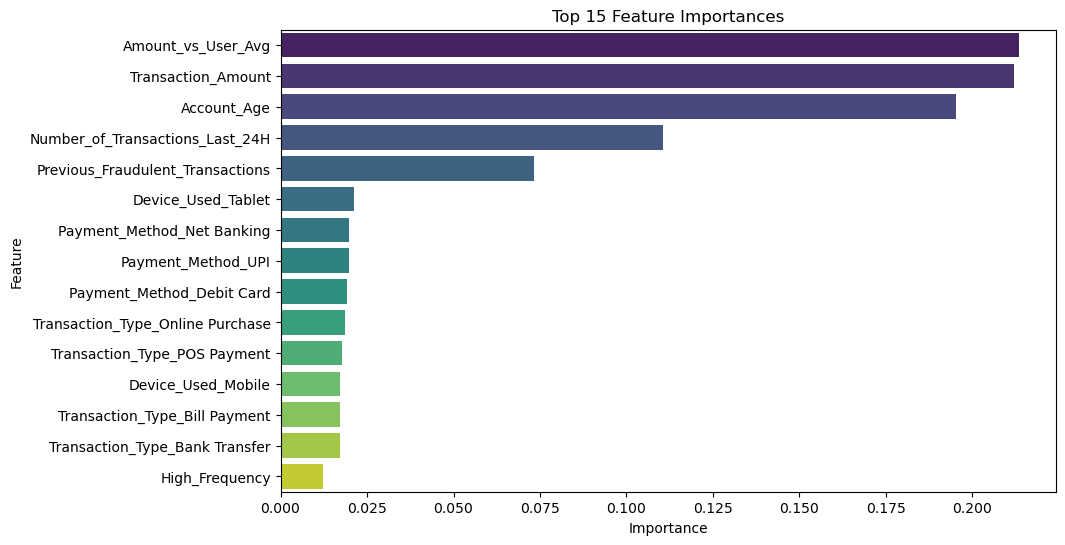

In [6]:


# Extract feature importances
importances = model.feature_importances_
features = X_train.columns

feat_imp = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp.head(15), palette='viridis')
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


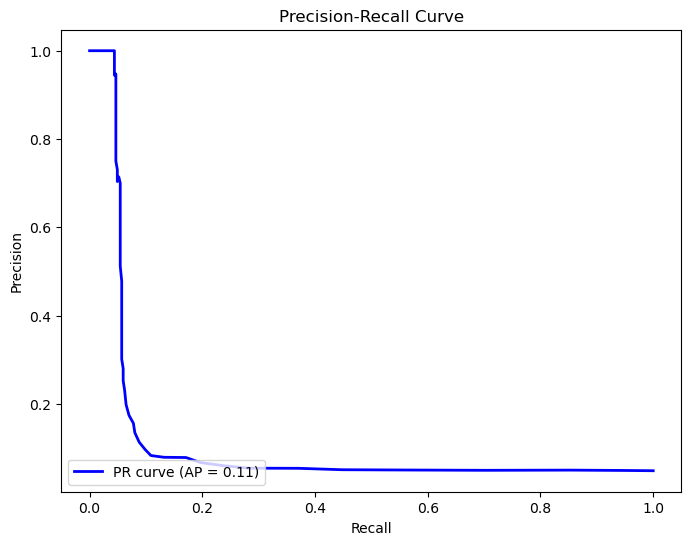

In [7]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


In [8]:


# Save the trained Random Forest
joblib.dump(model, 'fraud_detection_model.joblib')
# Save columns
joblib.dump(X_train.columns.tolist(), 'model_features.joblib')

print("Model saved as fraud_detection_model.joblib")


Model saved as fraud_detection_model.joblib


In [9]:
model_features = joblib.load('model_features.joblib')
print(model_features)
# Load the model back

loaded_model = joblib.load('fraud_detection_model.joblib')

# Example: predict again
y_pred_loaded = loaded_model.predict(X_test)


print("Loaded model works! Example prediction:", y_pred_loaded[:5])


['Transaction_Amount', 'Amount_vs_User_Avg', 'Is_Night_High', 'Number_of_Transactions_Last_24H', 'High_Frequency', 'Previous_Fraudulent_Transactions', 'Account_Age', 'Transaction_Type_Bank Transfer', 'Transaction_Type_Bill Payment', 'Transaction_Type_Online Purchase', 'Transaction_Type_POS Payment', 'Device_Used_Mobile', 'Device_Used_Tablet', 'Device_Used_Unknown Device', 'Payment_Method_Debit Card', 'Payment_Method_Invalid Method', 'Payment_Method_Net Banking', 'Payment_Method_UPI']
Loaded model works! Example prediction: [0 0 0 0 0]


# Summary

This project develops a fraud detection system using a Random Forest model to identify suspicious transactions based on user spending behavior, transaction timing, frequency, device, and payment patterns. After cleaning the data and engineering key features like unusual amount flags and transaction frequency spikes, the model was trained with balanced class weights to handle fraud’s rarity. Evaluation was done using precision-recall and ROC curves, and the final trained model is saved for reuse, providing a solid baseline for catching potential fraud in real-world scenarios.